# Проект Моторика

## Часть 2.1 Распознавание команд 

Цель данного ноутбука - построение  DL модели для распознавания команд.  Вся EDA часть и разработка ML модели на основе классических алгоритмов осуществлена локально. 



### Подготовка данных

In [ ]:
!pwd
!cp -invr /content/drive/MyDrive/Motorica/Data /content/Data
!nvidia-smi -L

/content
'/content/drive/MyDrive/Motorica/Data' -> '/content/Data'
'/content/drive/MyDrive/Motorica/Data/X_test.npy' -> '/content/Data/X_test.npy'
'/content/drive/MyDrive/Motorica/Data/y_train.csv' -> '/content/Data/y_train.csv'
'/content/drive/MyDrive/Motorica/Data/X_train.npy' -> '/content/Data/X_train.npy'
'/content/drive/MyDrive/Motorica/Data/new_targ.npy' -> '/content/Data/new_targ.npy'
'/content/drive/MyDrive/Motorica/Data/ext_targ.npy' -> '/content/Data/ext_targ.npy'
'/content/drive/MyDrive/Motorica/Data/ext_train.npy' -> '/content/Data/ext_train.npy'
GPU 0: Tesla T4 (UUID: GPU-e4ad9c03-b169-320d-a6cd-88f0be2c2261)


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold


In [ ]:
# Для обучения разработан набор большего объема данных, увеличенный в два раза за счет случайного сдвига каждого наблюдения в диапазоне -15..+15 отсчетов
extended_set = False
if extended_set : 
  X_train = np.load('./Data/ext_train.npy')  # train увеличен в два раза 
  y_train = np.load('./Data/ext_targ.npy') # увеличен в два раза
else: 
  X_train = np.load('./Data/X_train.npy')  # train предоставлен организаторами
  y_train = np.load('./Data/new_targ.npy') #pd.read_csv('./Data/y_train.csv')

X_test = np.load('./Data/X_test.npy')
# new_targ.npy - новая разметка данных, сгенерирована на этапе EDA, отличается моментом переключения.
print('X train:', X_train.shape); print('X_test:', X_test.shape); print('y_train:', y_train.shape)

X train: (646, 40, 100)
X_test: (54, 40, 100)
y_train: (646, 100)


Подготовка исходных данных: 
- удаление слабых сигналов,
- нормализация по уровню,
- измененение порядка осей для реккурентных слоев.

In [ ]:
min_sens_value = 200.
# нахожу сенсоры под удаление
sens2delete = np.flatnonzero(np.apply_over_axes(np.max, X_train, [0,2]).flatten() < min_sens_value) 
print('Sensors to delete',sens2delete.shape[0])
# удаляю данные по этим сенсорам из первоначального массива.
X_train = np.delete(X_train, sens2delete, axis=1)
X_test = np.delete(X_test, sens2delete, axis=1)
print('X train:', X_train.shape); print('X_test:', X_test.shape)
# нормализую по уровню максимального наблюдения
global_max = X_train.max(); print('Max Lvl:', global_max)
X_train_n = X_train / global_max
X_test_n = X_test / global_max

Sensors to delete 24
X train: (646, 16, 100)
X_test: (54, 16, 100)
Max Lvl: 3705.0


In [ ]:
small_sens_variation = 0.02
# Нахожу и удаляю сенсоры с малым СКО
sensor_var = np.std(X_train_n.swapaxes(0,1).reshape((X_train_n.shape[1],-1)),1)
small_var_sens = np.flatnonzero(sensor_var < small_sens_variation)
print('Sensor channels with small variations',small_var_sens)
if len(small_var_sens) > 0:
  X_train_n = np.delete(X_train_n, small_var_sens, axis = 1 )
  X_test_n = np.delete(X_test_n, small_var_sens, axis=1)
print('X train:', X_train_n.shape); print('X_test:', X_test_n.shape)  

Sensor channels with small variations [13]
X train: (646, 15, 100)
X_test: (54, 15, 100)


In [ ]:

# меняю местами оси и расширяю таргет
X_train_n = X_train_n.swapaxes(1, 2)
X_test_n = X_test_n.swapaxes(1, 2)
y_train_n = tf.keras.utils.to_categorical(y_train)
print('X train:', X_train_n.shape); print('X_test:', X_test_n.shape); print('y_train:', y_train_n.shape)

X train: (646, 100, 15)
X_test: (54, 100, 15)
y_train: (646, 100, 9)


In [ ]:
#ind_full = np.arange(X_full_n.shape[0])
X_trn, X_val, y_trn, y_val = train_test_split(X_train_n, y_train_n, test_size=0.15, shuffle=True, random_state=0)
print('X_trn:', X_trn.shape); print('y_trn:', y_trn.shape); 
print('X_val:', X_val.shape); print('y_val:', y_val.shape);
# print('Valuation samples:', ind_val)

X_trn: (549, 100, 15)
y_trn: (549, 100, 9)
X_val: (97, 100, 15)
y_val: (97, 100, 9)


### Архитектура модели

In [ ]:
input_channels = x = tf.keras.layers.Input(
    (X_train_n.shape[1], X_train_n.shape[2]),
)
x = tf.keras.layers.SimpleRNN(
    units=100,
    return_sequences=True,
    recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-3),
    dropout=0.0,
    recurrent_dropout=0.0,
)(x)
x = tf.keras.layers.SimpleRNN(
    units=100,
    return_sequences=True,
    recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-3),
    dropout=0.0,
    recurrent_dropout=0.0,
)(x)
x = tf.keras.layers.Dense(units=256, 
                          activation='relu', 
                          bias_regularizer=tf.keras.regularizers.l2(1e-4), 
                          activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

output = tf.keras.layers.Dense(units=9, activation='sigmoid')(x)

model = tf.keras.Model( inputs=input_channels, outputs=output, name="RNN_Model" )

In [ ]:
model.compile( loss="categorical_crossentropy", 
              metrics=[ "accuracy",],
              optimizer=tf.keras.optimizers.Adam(), # learning_rate=1e-2,  Adam(ExponentialDecay(1e-3, 100, 0.96)),  
)
model.summary()

Model: "RNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 15)]         0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 100)          11600     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100, 100)          20100     
                                                                 
 dense (Dense)               (None, 100, 256)          25856     
                                                                 
 batch_normalization (BatchN  (None, 100, 256)         1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                         

### Обучение модели

In [ ]:
# Добавим ModelCheckpoint. 
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.hdf5', 
                             monitor = 'val_accuracy', #'accuracy'
                             verbose = 1, 
                             mode = 'max', 
                             save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',  #'accuracy'
                          patience = 40, 
                          restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit( X_trn, y_trn, 
                    epochs=200, 
                    verbose=1, 
                    callbacks = callbacks_list,
                    validation_data=(X_val, y_val))


Epoch 1/200
18/18 [==============================] - ETA: 0s - loss: 17.0519 - accuracy: 0.5957
Epoch 1: val_accuracy improved from -inf to 0.58454, saving model to best_model.hdf5
18/18 [==============================] - 8s 187ms/step - loss: 17.0519 - accuracy: 0.5957 - val_loss: 16.8287 - val_accuracy: 0.5845
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 15.1209 - accuracy: 0.8037
Epoch 2: val_accuracy improved from 0.58454 to 0.75856, saving model to best_model.hdf5
18/18 [==============================] - 3s 171ms/step - loss: 15.1209 - accuracy: 0.8037 - val_loss: 15.2862 - val_accuracy: 0.7586
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 13.6817 - accuracy: 0.8451
Epoch 3: val_accuracy improved from 0.75856 to 0.77299, saving model to best_model.hdf5
18/18 [==============================] - 3s 158ms/step - loss: 13.6817 - accuracy: 0.8451 - val_loss: 13.8108 - val_accuracy: 0.7730
Epoch 4/200
18/18 [==============================] -

Training of 200 epochs, best val accuracy at epoch# 182 



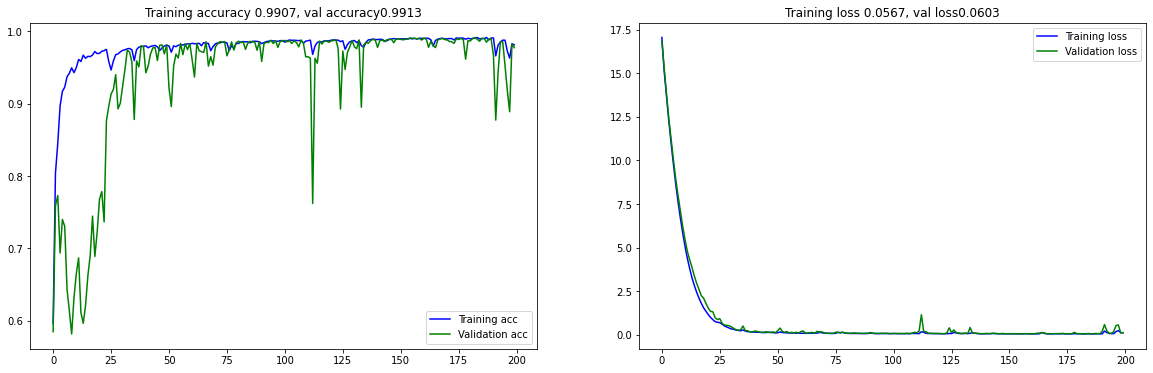

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))
# plt.figure(figsize=(10,4))
#plt.style.use('dark_background')
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
best_pos = np.argmax(val_acc)
best_acc = acc[best_pos]
best_val_acc = val_acc[best_pos]
best_loss = loss[best_pos]
best_val_loss = val_loss[best_pos]
acc_title = 'Training accuracy ' + str(round(best_acc,4)) +', val accuracy'+str(round(best_val_acc,4))
loss_title = 'Training loss ' +str(round(best_loss,4)) + ', val loss' + str(round(best_val_loss,4))
print('Training of',len(acc),'epochs, best val accuracy at epoch#', best_pos,'\n')
ax1.plot(epochs, acc, 'b', label='Training acc')
ax1.plot(epochs, val_acc, 'g', label='Validation acc')
ax1.set_title(acc_title)
ax1.legend()
#plt.figure(figsize=(10,4))
#plt.style.use('dark_background')
ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'g', label='Validation loss')
ax2.set_title(loss_title)
ax2.legend()
plt.show();

In [ ]:
model.load_weights('best_model.hdf5')
scores = model.evaluate(X_train_n, y_train_n, verbose=1)
print("Accuracy: %.4f" % (scores[1]))



21/21 [==============================] - 0s 19ms/step - loss: 0.0519 - accuracy: 0.9920
Accuracy: 0.9920


In [ ]:
# сохранение для последующего использования
accur = str(round(scores[1]*100000))
model_path = '/content/drive/MyDrive/Motorica/Models/'
model.save_weights(model_path + '/RNN1_acc_'+accur+'.hdf5')

### Визуализация данных

In [ ]:
want2visualise = True  # или True
if want2visualise :
  y_pred_train_n = model.predict(X_train_n)
  y_pred_train_n.shape

In [ ]:
if want2visualise :
  i = 24
  print('Train, command',1)
  commands = ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
  y_ticks = np.arange(9)

  fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12, 10))

  ax[0].plot(X_train[i].T)
  ax[0].set_title('Sensors')

  ax[1].imshow(y_train_n[i].T, origin="lower")
  ax[1].set_aspect('auto')
  ax[1].set_title('Command')
  ax[1].set_yticks(y_ticks)
  ax[1].set_yticklabels(commands) #( np.arange(9), commands) 

  ax[2].imshow(y_pred_train_n[i].T, origin="lower") # , vmin=-0.5, vmax=0.5
  ax[2].set_aspect('auto')
  ax[2].set_title('Model output')
  ax[2].set_yticks(y_ticks)
  ax[2].set_yticklabels(commands) #( np.arange(9), commands) 

  ax[3].plot(y_pred_train_n[i].argmax(axis=-1))
  ax[3].set_aspect('auto')
  ax[3].set_title('Actual Gesture')
  ax[3].set_yticks(y_ticks)
  ax[3].set_yticklabels(commands) #( np.arange(9), commands) 
  ax[3].set_xlabel('Timestep')

  #plt.suptitle(f'Train {i}')
  plt.tight_layout()
  plt.gcf();

### Формирование предсказания для Kaggle

In [ ]:
want2submit = True # False  # или True
subm_path = '/content/drive/MyDrive/Motorica/Submissions/'
subm_name = '220919_09.csv'

In [ ]:
if want2submit :
  y_pred_n = model.predict(X_test_n).argmax(axis=-1)
  print(y_pred_n.shape)
  y_pred_n


(54, 100)


In [ ]:
# Попытка сдвинуть предсказание на несколько отсчетов влево и улучшить результат
want2shift = False
if want2submit and want2shift :
  last = y_pred_n[:,-1]
  new_pred = np.insert(y_pred_n, 99, last, axis=1)[:,1:101]
  y_pred_n = np.insert(new_pred, 99, last, axis=1)[:,1:101]
  # y_pred_n = np.insert(new_pred, 99, last, axis=1)[:,1:101]
  y_pred_n.shape



In [ ]:
if want2submit :
  # Генерирую индекс для теста
  len_data = 323 if extended_set else X_train.shape[0]    # число наблюдений в трейне
  len_test = y_pred_n.shape[0]   # число наблюдений в  тесте
  len_test_steps = y_pred_n.shape[1]  # число измерений в тесте
  test_index = [ str(i)+'-' + str(j)  for i in range(len_data, len_data + len_test) for j in range(len_test_steps)  ]
  test_out = pd.Series(data=y_pred_n.flatten(), index=test_index, name='class')
  test_out.to_csv(subm_path+subm_name,index_label='sample-timestep')

Kagle Score
Простая RNN: 
- MVP  0.95740  при accuracy 0.9616
- 0.96407 при accuracy 0.9830
- 0.95851 при accuracy 0.97884, val_acc 0.9794
- 0.97000 при accuracy 0.9850
- 0.97296 при accuracy 0.9891
- 0.97185 при val_accuracy 0.9845

Удлинненная RNN:
- 0.97777 при overall accuracy 0.9920 за 200 эпох